In [1]:
import numpy as np
import scipy.signal as spsig
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time
from tqdm.notebook import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=1a2262d1a96843069cb61b290861773992ad812b880c3a68a10c1ddf8bcf46cb
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


In [9]:
#@title SimPSFToolkit definition

class SimPSFToolkit(object):
    """Simulate PSFs.
    
    In the future the zernike maps could be created with galsim.
    
    Parameters
    ----------
    zernike_maps
    pad_factor=2
    max_order=45
    max_wfe: float
        Maximum allowed WFE at ``lambda_norm``. Used for
        normalization. Units in [\mu m].
        Default is ``0.1``.
    lambda_norm: float
        Corresponds to the wavelength at which the normalization 
        of the WFE is taking place. Units in [\mu m].
        Default is ``0.550``.
    rand_seed=None
    plot_opt=True
    
    """
    
    def __init__(self, zernike_maps, max_order=45, max_wfe_rms=0.1,
                 output_dim=64, rand_seed=None, plot_opt=False, oversampling_rate=2,
                 pix_sampling=12, tel_diameter=1.2, tel_focal_length=24.5,
                 pupil_diameter=1024, euclid_obsc=True, LP_filter_length=3, verbose=0):
        # Input attributes
        self.max_order = max_order
        self.rand_seed = rand_seed
        self.plot_opt = plot_opt
        self.zernike_maps = zernike_maps
        self.max_wfe_rms = max_wfe_rms  # In [um]
        self.output_dim = output_dim  # In pixels per dimension
        self.verbose = verbose
        
        
        # Telescope characteristics
        self.oversampling_rate = oversampling_rate  # dimensionless
        self.pix_sampling = pix_sampling  # In [um]
        self.tel_diameter = tel_diameter  # In [m]
        self.tel_focal_length = tel_focal_length  # In [m]
        self.pupil_diameter = pupil_diameter  # In [pix]
        
        # Class attributes
        self.z_coeffs = None
        self.psf = None
        self.opd = None
        self.phase = None
        self.lambda_obs = None
        self.poly_psf = None
        
        # Generate pupil mask
        self.pupil_mask = ~np.isnan(self.zernike_maps[0])
        
        # Generate obscurations
        if euclid_obsc:
            self.obscurations = self.generate_pupil_obscurations(N_pix=pupil_diameter, N_filter=LP_filter_length)
        else:
            self.obscurations = np.ones((pupil_diameter, pupil_diameter))    
        
        
    @staticmethod
    def _OLD_fft_diffraction_op(wf, pupil_mask, pad_factor=2, match_shapes=True):
        """ Perform a fft-based diffraction.

        Parameters
        ----------
        wf: np.ndarray
            A complex 2D array that corresponds to the wavefront function.
        pupil_mask: np.ndarray of bools
            A 2D boolean mask that corresponds to the pupil function.


        Returns
        -------
        psf: np.ndarray
            A real 2D array corresponding to the PSF.

        """
        start = (wf.shape[0]*pad_factor)//2 - wf.shape[0]//2
        stop = (wf.shape[0]*pad_factor)//2 + wf.shape[0]//2

        padded_wf = np.zeros((wf.shape[0]*pad_factor, wf.shape[1]*pad_factor), dtype=np.complex128)

        padded_wf[start:stop, start:stop][pupil_mask] = wf[pupil_mask]

        fft_wf = np.fft.fftshift(np.fft.fft2(padded_wf))
        # fft_wf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(padded_wf)))
        
        psf = np.abs(fft_wf)**2
        
        if match_shapes:
            # Return the psf with its original shape without the padding factor
            x_dif = int((psf.shape[0]/pad_factor)//2)
            y_dif = int((psf.shape[1]/pad_factor)//2)        

            return psf[x_dif :psf.shape[0]-x_dif, y_dif :psf.shape[1]-y_dif]
        else:
            return psf
    
    
    @staticmethod
    def fft_diffract(wf, output_dim=64):
        # Perform the FFT-based diffraction operation
        fft_wf = np.fft.fftshift(np.fft.fft2(wf))
        psf = np.abs(fft_wf)**2
        
        # Crop the image
        start = int(psf.shape[0]//2-output_dim//2)
        stop = int(psf.shape[0]//2+output_dim//2)        

        return psf[start:stop, start:stop]

    @staticmethod
    def generate_pupil_obscurations(N_pix=1024, N_filter=3):
        """Generate Euclid like pupil obscurations.

        Simple procedure considering only the 2D plane.
        No 3D projections wrt the angle of the FoV is done.

        Parameters
        ----------
        N_pix: int
            Total number of pixels
        N_filter: int
            Length of the low-pass filter [pixels]

        """
        # Telescope parameters
        AS_diam = 1200  # Aperture stop diameter [mm]
        M1_diam = 395  # Mirror 1 cap stopper diameter [mm]

        sp_lenght = 700  # Spider length [mm]
        sp_width = 12  # Spider width [mm] 

        AS_centre = [0, 0]
        M1_centre = [0, 51]

        sp1_angle = 106.78 - 90 # [degrees]
        sp2_angle = 50.11 - 90 # [degrees]
        sp3_angle = -10.76 - 90 # [degrees]

        sp1_x_pos = 260  # [mm]
        sp1_y_pos = 240  # [mm]
        sp2_x_pos = -330  # [mm]
        sp2_y_pos = 130  # [mm]
        sp3_x_pos = 70  # [mm]
        sp3_y_pos = -330  # [mm]


        # Build pupil plane
        pupil_plane = np.ones((N_pix, N_pix))

        # coordinates of map in [mm]
        W, H  = np.meshgrid(np.linspace(-AS_diam//2, AS_diam//2, N_pix), np.linspace(-AS_diam//2, AS_diam//2, N_pix)) 


        ### Calculate the Aperture stop and draw it ###
        aperture_stop_mask = np.sqrt((W - AS_centre[0])**2 + (H - AS_centre[1])**2) <= (AS_diam/2) 
        pupil_plane[~aperture_stop_mask] = 0


        ### Calculate the M1/M2 obscurations and draw them ###
        M1_mask = np.sqrt((W - M1_centre[0])**2 + (H - M1_centre[1])**2) <= (M1_diam/2)
        pupil_plane[M1_mask] = 0


        ### Calculate the spiders and draw them ###

        # Spider 1
        sp1_a = np.tan(sp1_angle*(np.pi/180))
        sp1_b = sp1_y_pos - sp1_a*sp1_x_pos

        sp1_mask_1 = sp1_a*W + sp1_b - sp_width/2 * np.sqrt(1 + sp1_a**2) < H
        sp1_mask_2 = sp1_a*W + sp1_b + sp_width/2 * np.sqrt(1 + sp1_a**2) > H
        sp1_mask = np.logical_and(sp1_mask_1, sp1_mask_2)

        sp1_length_mask = np.sqrt((W - sp1_x_pos)**2 + (H - sp1_y_pos)**2) <= (sp_lenght/2)
        sp1_mask = np.logical_and(sp1_mask, sp1_length_mask)

        # Spider 2
        sp2_a = np.tan(sp2_angle*(np.pi/180))
        sp2_b = sp2_y_pos - sp2_a*sp2_x_pos

        sp2_mask_1 = sp2_a*W + sp2_b - sp_width/2 * np.sqrt(1 + sp2_a**2) < H
        sp2_mask_2 = sp2_a*W + sp2_b + sp_width/2 * np.sqrt(1 + sp2_a**2) > H
        sp2_mask = np.logical_and(sp2_mask_1, sp2_mask_2)

        sp2_length_mask = np.sqrt((W - sp2_x_pos)**2 + (H - sp2_y_pos)**2) <= (sp_lenght/2)
        sp2_mask = np.logical_and(sp2_mask, sp2_length_mask)

        # Spider 3
        sp3_a = np.tan(sp3_angle*(np.pi/180))
        sp3_b = sp3_y_pos - sp3_a*sp3_x_pos

        sp3_mask_1 = sp3_a*W + sp3_b - sp_width/2 * np.sqrt(1 + sp3_a**2) < H
        sp3_mask_2 = sp3_a*W + sp3_b + sp_width/2 * np.sqrt(1 + sp3_a**2) > H
        sp3_mask = np.logical_and(sp3_mask_1, sp3_mask_2)

        sp3_length_mask = np.sqrt((W - sp3_x_pos)**2 + (H - sp3_y_pos)**2) <= (sp_lenght/2)
        sp3_mask = np.logical_and(sp3_mask, sp3_length_mask)

        # Draw the three spider arms
        pupil_plane[sp1_mask] = 0
        pupil_plane[sp2_mask] = 0
        pupil_plane[sp3_mask] = 0


        ### Low-pass filter the image ###
        top_hat_filter = np.ones((N_filter, N_filter))

        pupil_plane = spsig.convolve2d(
        pupil_plane, top_hat_filter, boundary='fill', mode='same', fillvalue=0)

        pupil_plane /= np.sum(top_hat_filter)

        return pupil_plane
    
    
    @staticmethod
    def crop_img(to_crop_img, ref_im):
        cent_x = int(to_crop_img.shape[0]//2)
        cent_y = int(to_crop_img.shape[1]//2)
        
        delta_x = int(ref_im.shape[0]//2)
        delta_y = int(ref_im.shape[1]//2)
        
        return to_crop_img[ cent_x-delta_x : cent_x+delta_x , cent_y-delta_y : cent_y+delta_y ]
        
    
    @staticmethod
    def decimate_im(input_im, decim_f):
        """Decimate image.
        
        Decimated by a factor of decim_f.
        Based on the PIL library using the default interpolator.
        
        """

        pil_im = PIL.Image.fromarray(input_im)
        (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
        im_resized = pil_im.resize((width, height))

        return np.array(im_resized)
    
    
    @staticmethod
    def get_radial_idx(max_order=45):
        it=1
        radial_idxs = []

        while(len(radial_idxs)<=max_order):
            for _it in range(it):
                radial_idxs.append(it-1)

            it+=1

        return np.array(radial_idxs)

    
    @staticmethod
    def psf_plotter(psf, lambda_obs=0.000, cmap='gist_stern', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(psf, cmap=cmap, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_xticks([]);ax1.set_yticks([])
        ax1.set_title('PSF (lambda=%.3f [um])'%(lambda_obs))

        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(np.sqrt(abs(psf)), cmap=cmap, interpolation='None')
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('sqrt PSF (lambda=%.3f [um])'%(lambda_obs))
        ax2.set_xticks([]);ax2.set_yticks([])

        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.log(abs(psf)), cmap=cmap, interpolation='None')
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('log PSF (lambda=%.3f [um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./PSF_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    @staticmethod
    def opd_phase_plotter(pupil_mask, opd, phase, lambda_obs, cmap='viridis', save_img=False):
        fig = plt.figure(figsize=(18,10))
        
        ax1 = fig.add_subplot(131)
        im1 = ax1.imshow(pupil_mask, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('Pupil mask')
        ax1.set_xticks([]);ax1.set_yticks([])

        vmax = np.max(abs(opd))
        ax2 = fig.add_subplot(132)
        im2 = ax2.imshow(opd, cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax2, orientation='vertical')
        ax2.set_title('OPD [um]')
        ax2.set_xticks([]);ax2.set_yticks([])
        
        vmax = np.max(abs(np.angle(phase)))
        ax3 = fig.add_subplot(133)
        im3 = ax3.imshow(np.angle(phase), cmap=cmap, interpolation='None', vmin=-vmax, vmax=vmax)
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax3, orientation='vertical')
        ax3.set_title('W phase [rad](wv=%.2f[um])'%(lambda_obs))
        ax3.set_xticks([]);ax3.set_yticks([])
        
        if save_img:
            plt.savefig('./OPD_lambda_%.3f.pdf'%lambda_obs, bbox_inches='tight')

        plt.show()

        
    def get_psf(self):
        if self.psf is not None:
            return self.psf
        else:
            print('No PSF has been computed yet.')

            
    def plot_psf(self, cmap='gist_stern', save_img=False):
        if self.psf is not None:
            self.psf_plotter(self.psf,self.lambda_obs, cmap, save_img)
        else:
            print('No PSF has been computed yet.')

            
    def plot_opd_phase(self, cmap='viridis', save_img=False):
        if self.opd is not None:
            self.opd_phase_plotter(self.pupil_mask*self.obscurations,
                                   self.opd*self.obscurations,
                                   self.phase, self.lambda_obs,
                                   cmap, save_img)
        else:
            print('No WF has been computed yet.')

            
    def gen_random_Z_coeffs(self, max_order=45, rand_seed=None):
        """ Generate a random set of Zernike coefficients.

        The coefficients are generated following a uniform law U~[-1,1] 
        divided by their radial zernike index. 
        Ex: u_i / r(i) (u_i is a realization of U)

        Parameters
        ----------
        max_order: int
            Maximum order of Zernike polynomials.
        rand_seed: int
            Seed for the random initialization.

        Returns
        -------
        rand_coeffs: list of floats
            List containing the random coefficients.

        """
        if rand_seed is not None:
            np.random.seed(rand_seed)

        rad_idx = self.get_radial_idx(max_order)
        rad_idx[0] = 1 
        
        z_coeffs = []

        for it in range(max_order):
            z_coeffs.append((np.random.rand()-0.5)*2./rad_idx[it])

        self.z_coeffs = z_coeffs

        
    def plot_z_coeffs(self, save_img=False):
        """Plot random Zernike coefficients."""
        if self.z_coeffs is not None:
            fig = plt.figure(figsize=(12,6))
            ax1 = fig.add_subplot(111)
            im1 = ax1.bar(np.arange(len(self.z_coeffs)), np.array(self.z_coeffs))
            ax1.set_xlabel('Zernike coefficients')
            ax1.set_ylabel('Magnitude')
            
            if save_img:
                plt.savefig('./Z_coeffs.pdf', bbox_inches='tight')
                
            plt.show()
        else:
            print('Random coeffs not generated.')
          

    def get_z_coeffs(self):
        """Get random coefficients"""
        if self.z_coeffs is not None:
            return self.z_coeffs
        else:
            print('Random coeffs not generated.')

            
    def set_z_coeffs(self, z_coeffs):
        """Set zernike coefficients."""
        if len(z_coeffs) == self.max_order:
            self.z_coeffs = z_coeffs
        else:
            print('Zernike coefficients should be of length %d'%(self.max_order))
     
    
    def normalize_zernikes(self, z_coeffs=None, max_wfe_rms=None):
        """Normalize zernike coefficients."""
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
            
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        mult_factor = max_wfe_rms / wfe_rms
        
        # Normalize Zernike coefficients and return them
        z_coeffs = [_z*mult_factor for _z in z_coeffs]
        
        return z_coeffs
    
    def calculate_wfe_rms(self, z_coeffs=None):
        """Calculate WFE rms from a set of zernike coefficients."""
        if z_coeffs is None:
            if self.z_coeffs is None:
                self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
                z_coeffs = self.get_z_coeffs()
            else:
                z_coeffs = self.get_z_coeffs()
                  
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Proyect obscurations on to the OPD
        opd *= self.obscurations
        
        # Calculate normalization factor
        wfe_rms = np.sqrt(np.mean((opd[self.pupil_mask] -np.mean(opd[self.pupil_mask]))**2))
        
        return wfe_rms
    
    def check_wfe_rms(self, z_coeffs=None, max_wfe_rms=None):
        """Check if Zernike coefficients are within the maximum admitted error."""
        
        if max_wfe_rms is None:
            max_wfe_rms = self.max_wfe_rms
        
        # Calculate normalization factor
        wfe_rms = self.calculate_wfe_rms(z_coeffs=z_coeffs)
        
        return max_wfe_rms - wfe_rms
        
        
    def generate_mono_PSF(self, lambda_obs=0.725, regen_sample=False, get_psf=False):
        """Generate monochromatic PSF."""
        if lambda_obs<0.55*0.95 or lambda_obs>0.9*0.95:
            print('WARNING: requested wavelength %.4f um is not in VIS passband [0.55,0.9]um'%(lambda_obs))
        self.lambda_obs = lambda_obs
        
        # Calculate the OPD from the Zernike coefficients
        self.calculate_opd(regen_sample)
          
        # Apply the diffraction operator using the opd (optical path differences)
        self.diffract_phase()
        
        if get_psf is True:
            return np.copy(self.psf)
    
    def calculate_opd(self, regen_sample=False):
        """Calculate the OPD from the Zernike coefficients."""
        if self.z_coeffs is None or regen_sample is True:
            # Generate a random sample of coefficients
            self.gen_random_Z_coeffs(self.max_order, self.rand_seed)
            # Normalize coefficients
            z_coeffs = self.normalize_zernikes(self.get_z_coeffs(), self.max_wfe_rms)
            # Save coefficients
            self.set_z_coeffs(z_coeffs)  
            # Plot Zernike coefficients
            if self.plot_opt:
                self.plot_z_coeffs()

        else:
            # Get the stored Zernike coefficients
            z_coeffs = self.get_z_coeffs()
            
        
        # Create the phase with the Zernike basis
        opd = 0
        for it in range(self.max_order):
            opd += self.zernike_maps[it]*z_coeffs[it]
        
        # Save the wavefront
        self.opd = opd
        
    
    def diffract_phase(self, lambda_obs=None):
        """Diffract the phase map."""
        if lambda_obs is None:
            if self.lambda_obs is None:
                print('WARNING: No wavelength is defined. Using default value 0.8um.')
                lambda_obs = 0.8
            else: 
                lambda_obs = self.lambda_obs
        elif lambda_obs<0.55*0.99 or lambda_obs>0.9*1.01:
            print('WARNING: wavelength %.4f is not in VIS passband [0.55,0.9]um'%(lambda_obs))
            
        # Calculate the feasible lambda closest to lambda_obs
        possible_lambda = self.feasible_wavelength(lambda_obs)
        
        # Save wavelength
        self.lambda_obs = possible_lambda
        
        # Calculate the required N for the input lambda_obs
        possible_N = self.feasible_N(self.lambda_obs)
        
        # Generate the full phase and
        # Add zeros to the phase to have the correct fourier sampling
        start = possible_N//2 - self.opd.shape[0]//2
        stop = possible_N//2 + self.opd.shape[0]//2

        self.phase = np.zeros((possible_N, possible_N), dtype=np.complex128)
        self.phase[start:stop, start:stop][self.pupil_mask] = np.exp(
            2j*np.pi*self.opd[self.pupil_mask]/self.lambda_obs)
        
        # Project obscurations to the phase
        self.phase[start:stop, start:stop] *= self.obscurations
        
        # FFT-diffract the phase (wavefront) and then crop to desired dimension
        self.psf = self.fft_diffract(wf=self.phase, output_dim=self.output_dim)
        
        # Normalize psf
        self.psf /= np.sum(self.psf)

        
    def feasible_N(self, lambda_obs):
        """Calculate the feasible N for a lambda_obs diffraction.
        
        Input wavelength must be in [um].
        """
        # Calculate the required N for the input lambda_obs
        req_N = (
            self.oversampling_rate * self.pupil_diameter * lambda_obs * self.tel_focal_length)/ (
            self.tel_diameter * self.pix_sampling)
        # Recalculate the req_N into a possible value (a pair integer)
        possible_N = int((req_N//2)*2)
        
        return possible_N
    
    def feasible_wavelength(self, lambda_obs):
        """Calculate closest fesible wavelength to target wavelength.
        
        Input wavelength must be in [um].
        """
        # Calculate a feasible N for the input lambda_obs
        possible_N = self.feasible_N(lambda_obs)
        
        # Recalculate the corresponding the wavelength
        possible_lambda = (
            possible_N * self.tel_diameter * self.pix_sampling) / (
            self.pupil_diameter * self.oversampling_rate * self.tel_focal_length)
        
        if self.verbose > 0:
            print("Requested wavelength: %.5f \nRequired N: %.2f"%(lambda_obs, req_N))
            print("Possible wavelength: %.5f \nPossible N: %.2f"%(possible_lambda, possible_N))
            
        return possible_lambda
 
    
    @staticmethod
    def gen_SED_interp(SED, n_bins=35, interp_kind='cubic'):
        """Generate SED interpolator.
        
        Returns the interpolator and the wavelengths in [nm].
        """
        wv_max = 900
        wv_min = 550
        wvlength = np.arange(wv_min, wv_max, int((wv_max-wv_min)/n_bins))
        
        SED_interp = sinterp.interp1d(
            SED[:,0], SED[:,1], kind=interp_kind, bounds_error=False, fill_value="extrapolate")
        
        return wvlength, SED_interp
    
    def calc_SED_wave_values(self, SED, n_bins=35):
        """Calculate feasible wavelength and SED values.
        
        Feasable so that the padding number N is integer.
        """
        # Generate SED interpolator and wavelength array
        wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
        
        # Convert wavelength from [nm] to [um]
        wvlength_um = wvlength/1e3
        
        # Calculate feasible wavelengths (in [um])
        verbose = self.verbose
        self.verbose = 0
        feasible_wv = np.array([self.feasible_wavelength(_wv) for _wv in wvlength_um])
        self.verbose = verbose
        
        # Interpolate and normalize SED
        SED_norm = SED_interp(feasible_wv*1e3)  # Interpolation is done in [nm] 
        SED_norm /= np.sum(SED_norm)        
        
        return feasible_wv, SED_norm
 

    def generate_poly_PSF(self, SED, n_bins=35):
        """Generate polychromatic PSF with a specific SED.
        
        The wavelength space will be the Euclid VIS instrument band:
        [550,900]nm and will be sample in ``n_bins``.
        
        """
        # Calculate the feasible values of wavelength and the corresponding
        # SED interpolated values
        feasible_wv, SED_norm = self.calc_SED_wave_values(SED, n_bins)   
        
        if self.plot_opt:
            # Plot input SEDs and interpolated SEDs
            wvlength, SED_interp = self.gen_SED_interp(SED, n_bins)
            
            fig = plt.figure(figsize=(14,8))
            ax1 = fig.add_subplot(111)
            ax1.plot(SED[:,0],SED[:,1], label='Input SED')
            ax1.scatter(feasible_wv*1e3, SED_interp(feasible_wv*1e3), label='Interpolated', c='red')
            ax1.set_xlabel('wavelength [nm]')
            ax1.set_ylabel('SED(wavelength)')
            ax1.set_title('SED')
            ax1.legend()
            # plt.savefig(output_path+'SED_interp_nbin_%d.pdf'%n_bins, bbox_inches='tight')
            plt.show()
        
        stacked_psf = 0
        
        # Generate the required monochromatic PSFs
        for it in range(feasible_wv.shape[0]):          
            self.generate_mono_PSF(lambda_obs=feasible_wv[it])
            stacked_psf += self.get_psf()*SED_norm[it]
           
        self.poly_psf = stacked_psf
        
        return stacked_psf

    
# This pythonic version of the polychromatic calculation is not working
# The parallelisation with the class with shared variables might not be working
# It may work if we define a @staticmethod for the diffracvtion
#         psf_cube = np.array([_sed*self.generate_mono_PSF(_wv, get_psf=True) 
#                              for _wv, _sed in zip(feasible_wv, SED_norm)])
#         # Sum to obtain the polychromatic PSFs
#         self.poly_psf = np.sum(np_psf_cube, axis=0)
#         return np.copy(self.poly_psf)


# Import variables and datasets

In [10]:
def decimate_im(input_im, decim_f):
    """Decimate image.
    
    Decimated by a factor of decim_f.
    Based on the PIL library using the default interpolator.
    
    """

    pil_im = PIL.Image.fromarray(input_im)
    (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
    im_resized = pil_im.resize((width, height))

    return np.array(im_resized)

In [11]:
Zcube_path = '/content/drive/MyDrive/Colab Notebooks/psf_data/Zernike45.mat'
# Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
# Decimation factor for Zernike polynomials
decim_f = 2  # Original shape (1024x1024)

n_zernikes = 15

for it in range(n_zernikes):
    zernike_map = decimate_im(Zcube['Zpols'][0,it][5], decim_f)
    zernikes.append(zernike_map)

# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0

tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float64)

In [12]:
tf_zernike_cube.shape

TensorShape([15, 512, 512])

In [13]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/psf_field_dataset/'
# dataset_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/psf_field_datasets/'
# Load the dictionaries
train_dataset = np.load(dataset_path + 'stellar_SEDs_train_psf_field.npy', allow_pickle=True)[()]
test_dataset = np.load(dataset_path + 'stellar_SEDs_test_psf_field.npy', allow_pickle=True)[()]


In [14]:
train_stars = train_dataset['stars']
train_pos = train_dataset['positions']
train_SEDs = train_dataset['SEDs']

test_stars = test_dataset['stars']
test_pos = test_dataset['positions']
test_SEDs = test_dataset['SEDs']

In [15]:
train_SEDs.shape

(140, 352, 2)

In [16]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
printm()

Gen RAM Free: 11.7 GB  | Proc size: 1.5 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB


# Define the TF functions


## Monochromatic PSF modules

In [17]:
class TF_fft_diffract(tf.Module):
    def __init__(self, output_dim=64, name=None):
        super().__init__(name=name)
        self.output_dim = output_dim
    
    def crop_img(self, image):
        # Crop the image
        start = int(image.shape[0]//2-self.output_dim//2)
        stop = int(image.shape[0]//2+self.output_dim//2)        

        return image[start:stop, start:stop]
    
    def tf_crop_img(self, image):
        """Crop images with tf methods.
        
        It handles a batch of 2D images: [batch, width, height]
        """
        # start
        offset_height = int(image.shape[2]//2 - self.output_dim//2)
        offset_width = int(image.shape[1]//2 - self.output_dim//2)
        # stop
        target_height = int(self.output_dim)
        target_width = int(self.output_dim)
        
        # Crop image
        cropped_image = tf.image.crop_to_bounding_box(
            tf.transpose(image, perm=[1,2,0]),
#             tf.reshape(image, shape=(image.shape[0], image.shape[1], -1)),
            offset_height,
            offset_width,
            target_height,
            target_width)       

        return tf.transpose(cropped_image, perm=[2,0,1])
#         return tf.reshape(cropped_image, shape=(cropped_image.shape[0], cropped_image.shape[1])) 
    
    def normalize_psf(self, psf):
        # Sum over all the dimensions
#         norm_factor = tf.math.reduce_sum(psf)
        norm_factor = tf.math.reduce_sum(psf, axis=[1,2], keepdims=True)
        
        return psf/norm_factor
        
    
    def __call__(self, input_phase):
        """ Calculate the normalized PSF from the padded phase array.
        """
        # Perform the FFT-based diffraction operation
        # fft_phase = tf.signal.fftshift(tf.signal.fft2d(input_phase))
        fft_phase = tf.signal.fftshift(tf.signal.fft2d(input_phase[:,...]), axes=[1, 2])
        psf = tf.math.pow(tf.math.abs(fft_phase), 2)

        # Crop the image
        # cropped_psf = self.crop_img(psf)
        cropped_psf = self.tf_crop_img(psf)
        
        # Normalize the PSF
        norm_psf = self.normalize_psf(cropped_psf)
        
        return norm_psf


class TF_build_phase(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, name=None):
        super().__init__(name=name)
        
        self.phase_N = phase_N
        self.lambda_obs = lambda_obs
        self.obscurations = obscurations
         
    def zero_padding_diffraction(self, no_pad_phase):
        """ Pad with zeros corresponding to the required lambda. """
        # pad_num = int(self.phase_N//2 - no_pad_phase.shape[0]//2)
        # pure tensorflow
        start = tf.math.floordiv(tf.cast(self.phase_N, dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        stop = tf.math.floordiv(tf.cast(no_pad_phase.shape[0], dtype=tf.int32), tf.cast(2, dtype=tf.int32))
        pad_num = tf.math.subtract(start, stop) # start - stop

        padding = [
                   (0, 0),
                   (pad_num, pad_num),
                   (pad_num, pad_num)
                   ]

        return tf.pad(no_pad_phase, padding)
        
    def apply_obscurations(self, phase):
        """Multiply element-wise with the obscurations. """
        return tf.math.multiply(phase, tf.cast(self.obscurations, phase.dtype))
        
    
    def opd_to_phase(self, opd):
        """Convert from opd to phase."""
        pre_phase = tf.math.multiply(tf.cast((2*np.pi)/self.lambda_obs, opd.dtype), opd)
        phase = tf.math.exp(tf.dtypes.complex(tf.cast(0, pre_phase.dtype), pre_phase))
        return phase

    def __call__(self, opd):
        """Build the phase from the opd."""
        phase = self.opd_to_phase(opd)
        obsc_phase = self.apply_obscurations(phase)
        padded_phase = self.zero_padding_diffraction(obsc_phase)

        return padded_phase



class TF_zernike_OPD(tf.Module):
    """ Turn zernike coefficients into an OPD.
    
    Will use all of the Zernike maps provided.
    Both the Zernike maps and the Zernike coefficients must be provided.

    Parameters
    ----------
    zernike_maps: Tensor (Num_coeffs, x_dim, y_dim)
    z_coeffs: Tensor (num_star, num_coeffs, 1, 1)

    Returns
    -------
    opd: Tensor (num_star, x_dim, y_dim)
    
    """
    def __init__(self, zernike_maps, name=None):
        super().__init__(name=name)
        
        self.zernike_maps = zernike_maps
        
    def __call__(self, z_coeffs):
        # Perform the weighted sum of Zernikes coeffs and maps
        opd = tf.math.reduce_sum(tf.math.multiply(self.zernike_maps, z_coeffs), axis=1)
        return opd



class TF_Zernike_mono_PSF(tf.Module):
    """Build a monochromatic PSF from zernike coefficients.

    Following a Zernike model.
    """
    def __init__(self, phase_N, lambda_obs, obscurations, zernike_maps, output_dim=64, name=None):
        super().__init__(name=name)
        
        self.tf_build_opd_zernike = TF_zernike_OPD(zernike_maps)
        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)
        
    def __call__(self, z_coeffs):
        opd = self.tf_build_opd_zernike.__call__(z_coeffs)
        phase = self.tf_build_phase.__call__(opd)
        psf = self.tf_fft_diffract.__call__(phase)
    
        return psf


class TF_mono_PSF(tf.Module):
    def __init__(self, phase_N, lambda_obs, obscurations, output_dim=64, name=None):
        super().__init__(name=name)
        
        self.tf_build_phase = TF_build_phase(phase_N, lambda_obs, obscurations)
        self.tf_fft_diffract = TF_fft_diffract(output_dim)
          
    def __call__(self, opd):
        phase = self.tf_build_phase.__call__(opd)
        psf = self.tf_fft_diffract.__call__(phase)
    
        return psf



## Polychromatic PSF modules

In [18]:
def generate_SED_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the SED elements needed for using the TF_poly_PSF.
    
    sim_psf_toolkit: An instance of the SimPSFToolkit class with the correct 
    initialization values.
    """
    
    feasible_wv, SED_norm = sim_psf_toolkit.calc_SED_wave_values(SED, n_bins)  
    feasible_N = np.array([sim_psf_toolkit.feasible_N(_wv)  for _wv in feasible_wv])
    
    return feasible_N, feasible_wv, SED_norm


def generate_packed_elems(SED, sim_psf_toolkit, n_bins=20):
    """Generate the packed values for using the TF_poly_PSF."""
    feasible_N, feasible_wv, SED_norm = generate_SED_elems(SED, sim_psf_toolkit, n_bins=n_bins)
    
    tf_feasible_N = tf.convert_to_tensor(feasible_N, dtype=tf.float64)
    tf_feasible_wv = tf.convert_to_tensor(feasible_wv, dtype=tf.float64)
    tf_SED_norm = tf.convert_to_tensor(SED_norm, dtype=tf.float64)
    
    # returnes the packed tensors
    return [tf_feasible_N, tf_feasible_wv, tf_SED_norm]
    

class TF_poly_PSF(tf.Module):
    """Calculate a polychromatic PSF from an OPD and stored SED values.
    
    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class. 
    
    
    packed_elems: Tuple of tensors
        Contains three 1D tensors with the parameters needed for 
        the calculation of each monochromatic PSF.
    
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
    """
    def __init__(self, obscurations, packed_elems, output_dim=64, zernike_maps=None, name=None):
        super().__init__(name=name)
        
        self.obscurations = obscurations
        self.output_dim = output_dim
        self.packed_elems = packed_elems
        self.zernike_maps = zernike_maps
        
        self.opd = None
        
        
    def set_packed_elems(self, new_packed_elems):
        """Set packed elements."""
        self.packed_elems = new_packed_elems

    def set_zernike_maps(self, zernike_maps):
        """Set Zernike maps."""
        self.zernike_maps = zernike_maps

    def calculate_from_zernikes(self, z_coeffs):
        """Calculate polychromatic PSFs from zernike coefficients.
        
        Zernike maps required.
        """
        tf_zernike_opd_gen = TF_zernike_OPD(self.zernike_maps)
        # For readability
        # opd = tf_zernike_opd_gen.__call__(z_coeffs)
        # poly_psf = self.__call__(opd)
        # return poly_psf

        return self.__call__(tf_zernike_opd_gen.__call__(z_coeffs))

    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.
        
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]
        
        # Build the monochromatic PSF generator
        tf_mono_psf_gen = TF_mono_PSF(phase_N, lambda_obs, self.obscurations, output_dim=self.output_dim)
            
        # Calculate the PSF
        mono_psf = tf_mono_psf_gen.__call__(self.opd)
        
        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)

    def __call__(self, opd):
        
        # Save the OPD that will be shared by all the monochromatic PSFs
        self.opd = opd


        # Use tf.function for parallelization over GPU
        # Not allowed since the dynamic padding for the diffraction does not 
        # work in the @tf.function context
        # @tf.function
        def calculate_poly_PSF(elems_to_unpack):
            return tf.map_fn(self.calculate_mono_PSF, elems_to_unpack, parallel_iterations=1, fn_output_signature=tf.float64)
        
        stacked_psfs = calculate_poly_PSF(packed_elems)
        poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)
    
        return poly_psf


## PSF field modules

In [19]:
class TF_poly_Z_field(tf.Module):
    """ Calculate the zernike coefficients for a given position.
    
    This module implements a polynomial model of Zernike 
    coefficient variation.
    
    Parameters
    ----------
    n_zernikes: int
        Number of Zernike polynomials to consider
    d_max: int
        Max degree of polynomial determining the FoV variations.
    
    """
    def __init__(self, x_lims, y_lims, pos=None, n_zernikes=45, d_max=2, normalize=True, name=None):
        super().__init__(name=name)
        
        self.n_zernikes = n_zernikes
        self.d_max = d_max

        self.coeff_mat = None
        self.poly_mat = None
        self.x_lims = x_lims
        self.y_lims = y_lims
        
        if pos is not None:
            self.calc_poly_position_mat(pos, normalize)

    def get_poly_coefficients_shape(self):
        """ Return the shape of the coefficient matrix."""
        return (self.n_zernikes, int((self.d_max+1)*(self.d_max+2)/2))

    def set_coeff_matrix(self, coeff_mat):
        """ Set coefficient matrix."""
        self.coeff_mat = coeff_mat

    def calc_poly_position_mat(self, pos, normalize=True):
        """ Calculate a matrix with position polynomials."""
        _poly_mat = np.zeros((int((self.d_max+1)*(self.d_max+2)/2), pos.shape[0]))
        
        # Scale positions from the square:
        # [self.x_lims[0], self.x_lims[1]] x [self.y_lims[0], self.y_lims[1]]
        # to the square [0,1] x [0,1]
        pos[:,0] = (pos[:,0] - self.x_lims[0]) / self.x_lims[1]
        pos[:,1] = (pos[:,1] - self.y_lims[0]) / self.y_lims[1]

        for d in range(self.d_max + 1):
            row_idx = d * (d + 1) // 2
            for p in range(d + 1):
                _poly_mat[row_idx + p, :] = pos[:, 0] ** (d - p) * pos[:, 1] ** p

        if normalize:
            weight_norms = np.sqrt(np.sum(_poly_mat ** 2, axis=0))
            _poly_mat /= weight_norms.reshape(1, -1)

        self.poly_mat = tf.convert_to_tensor(_poly_mat, dtype=tf.float32)

    def __call__(self):
        """ Calculate the zernike coefficients for a given position.
        
        The position polynomial matrix and the coefficients should be 
        set before calling this function.
        
        Returns
        -------
        zernikes_coeffs: Tensor(batch, n_zernikes, 1, 1)
        """
        zernikes_coeffs = tf.cast(tf.linalg.matmul(self.coeff_mat, self.poly_mat), dtype=tf.float64)
        zernikes_coeffs = tf.transpose(zernikes_coeffs)
        
        return zernikes_coeffs[:, :, tf.newaxis, tf.newaxis]


    

class TF_batch_poly_PSF(tf.Module):
    """Calculate a polychromatic PSF from an OPD and stored SED values.
    
    The calculation of the packed values with the respective SED is done
    with the SimPSFToolkit class but outside the TF class. 
    
    

    obscurations: Tensor(pupil_len, pupil_len)
        Obscurations to apply to the wavefront.
        
    packed_SED_data: list(list(Tensor,Tensor,Tensor))
        Where each inner list consist of a packed_elem:
        
            packed_elems: Tuple of tensors
            Contains three 1D tensors with the parameters needed for 
            the calculation of one monochromatic PSF.
            
            packed_elems[0]: phase_N
            packed_elems[1]: lambda_obs
            packed_elems[2]: SED_norm_val
        The SED data is constant in a FoV.
        
    psf_batch: Tensor(num_psfs, output_dim, output_dim)
        Tensor containing the psfs that will be updated each
        time a calculation is required.
    
    """
    def __init__(self, obscurations, psf_batch, packed_SED_data, output_dim=64, zernike_maps=None, name=None):
        super().__init__(name=name)
        
        self.obscurations = obscurations
        self.output_dim = output_dim
        self.packed_SED_data = packed_SED_data
        self.zernike_maps = zernike_maps
        
        self.psf_batch = psf_batch
        
        self.opd_batch = None
        self.current_opd = None 
        
    def set_opd_batch(self, opd_batch):
        """Set OPD batch."""
        self.opd_batch = opd_batch
        
    def set_packed_elems(self, new_packed_elems):
        """Set packed elements."""
        self.packed_elems = new_packed_elems

    def set_zernike_maps(self, zernike_maps):
        """Set Zernike maps."""
        self.zernike_maps = zernike_maps
    
    def set_psf_batch(self, psf_batch):
        """Set poly PSF batch."""
        self.psf_batch = psf_batch

    def calculate_mono_PSF(self, packed_elems):
        """Calculate monochromatic PSF from packed elements.
        
        packed_elems[0]: phase_N
        packed_elems[1]: lambda_obs
        packed_elems[2]: SED_norm_val
        """
        # Unpack elements
        phase_N = packed_elems[0]
        lambda_obs = packed_elems[1]
        SED_norm_val = packed_elems[2]
        
        # Build the monochromatic PSF generator
        tf_mono_psf_gen = TF_mono_PSF(phase_N, lambda_obs, self.obscurations, output_dim=self.output_dim)
            
        # Calculate the PSF
        mono_psf = tf_mono_psf_gen.__call__(self.current_opd)
        
        # Multiply with the respective normalized SED and return
        return tf.math.scalar_mul(SED_norm_val, mono_psf)

    
    def calculate_poly_PSF(self, packed_elems):

        # Use tf.function for parallelization over GPU
        # Not allowed since the dynamic padding for the diffraction does not 
        # work in the @tf.function context
        # @tf.function
        def _calculate_poly_PSF(elems_to_unpack):
            return tf.map_fn(self.calculate_mono_PSF, elems_to_unpack, parallel_iterations=1, fn_output_signature=tf.float64, swap_memory=True)
        
        # Readability
        # stacked_psfs = _calculate_poly_PSF(packed_elems)
        # poly_psf = tf.math.reduce_sum(stacked_psfs, axis=0)
        # return poly_psf
        
        return tf.math.reduce_sum(_calculate_poly_PSF(packed_elems), axis=0)
    

    
    def calculate_batch(self):
        """Claculate the batch poly PSFs."""
        
        batch_num = self.opd_batch.shape[0]
        
        it = tf.constant(0)
        while_condition = lambda it: tf.less(it, batch_num)

        def while_body(it):
            # Extract the required data of _it_
            packed_elems = self.packed_SED_data[it]
            self.current_opd = self.opd_batch[it][tf.newaxis,:,:]
            
            # Calculate the _it_ poly PSF
            poly_psf = self.calculate_poly_PSF(packed_elems)
            
            # Update the poly PSF tensor with the result
            # Slice update of a tensor
            # See tf doc of _tensor_scatter_nd_update_ to understand
            indices = tf.reshape(it, shape=(1,1))
            self.psf_batch = tf.tensor_scatter_nd_update(self.psf_batch, indices, poly_psf)
            
            
            # increment i
            return [tf.add(it, 1)]

        # Loop over the PSF batches
        r = tf.while_loop(while_condition, while_body, [it], swap_memory=True)
        
        return self.psf_batch






In [20]:

class TF_PSF_field_model(tf.Module):
    """Model of the PSF field.
    
    Goes from position batch to polychromatic PSF batch.
    """
    def __init__(self, positions, x_lims, y_lims, packed_SED_data, psf_batch, obscurations, tf_zernike_cube,
                 output_dim=64, n_zernikes=15, d_max=2, normalize_pos=True, name=None):
        super().__init__(name=name)
        
        # Model parameters
        self.n_zernikes = n_zernikes
        self.d_max = d_max       
        self.output_dim = output_dim
        self.tf_zernike_cube = tf_zernike_cube
        
        # PSF field data
        self.positions = positions
        self.packed_SED_data = packed_SED_data
        self.psf_batch = psf_batch
        self.obscurations = obscurations
        self.x_lims = x_lims
        self.y_lims = y_lims
        
        # Further variables
        self.z_coef_batch = None
        self.opd_batch = None
        self.model_coef_mat = None
        
        # Initialize the different modules
        
        # Module: Position batch to Zernike coefficients batch
        self.tf_poly_Z_field = TF_poly_Z_field(x_lims=self.x_lims,
                                               y_lims=self.y_lims,
                                               pos=self.positions,
                                               n_zernikes=self.n_zernikes,
                                               d_max=self.d_max,
                                               normalize=normalize_pos,
                                               name='poly_Z_field')
        
        # Module: Zernike coefficients batch to batch OPD
        self.tf_zernike_OPD = TF_zernike_OPD(zernike_maps=self.tf_zernike_cube,
                                             name='zernike_to_opd')
        
        # Module: OPD batch to polychromatic PSF batch
        self.tf_batch_poly_PSF = TF_batch_poly_PSF(obscurations=self.obscurations,
                                                   psf_batch=self.psf_batch,
                                                   packed_SED_data=self.packed_SED_data,
                                                   output_dim=self.output_dim,
                                                   zernike_maps=None,
                                                   name='batch_poly_PSF')
        
        
        
    def set_model_params(self, model_coef_mat):
        """Set model parameters."""
        # Assert the shape of the model's coefficient matrix
        tf.debugging.assert_shapes([(model_coef_mat, self.tf_poly_Z_field.get_poly_coefficients_shape())])
        # Then save the model's coef matrix
        self.model_coef_mat = model_coef_mat
        # Store it in the corresponding module
        self.tf_poly_Z_field.set_coeff_matrix(self.model_coef_mat)
        
        
    def assert_shapes(self):
        """Verify shape integrity.
        
        All the variables should be initialized.
        
        n_z: Number of zernike polynomials to use.
        n_batch: Number of stars/positions to consider.
        pol_terms: Max number of polynomial terms in model variations.
        z_dim_x: X-dimension of the Zernike polynomial map
        z_dim_y: Y-dimension of the Zernike polynomial map
        out_dim: output PSF stamp dimension
        n_bins_lda: Number of wavelength bins

        """
        tf.debugging.assert_shapes([
            (self.n_zernikes,      ('n_z') ),
            (self.positions,       ('n_batch', 2) ),
            (self.tf_zernike_cube, ('n_z', 'z_dim_x', 'z_dim_y') ),
            (self.z_coef_batch,    ('n_batch', 'n_z', 1, 1) ),
            (self.model_coef_mat,  ('n_z', 'pol_terms') ),
            (self.opd_batch,       ('n_batch', 'z_dim_x', 'z_dim_y') ),
            (self.psf_batch,       ('n_batch', 'out_dim', 'out_dim') ),
            (self.obscurations,    ('z_dim_x', 'z_dim_y') ),
            (self.packed_SED_data, ('n_batch', 3, 'n_bins_lda') )
            ])
    
    
    def calculate_psf_batch(self):
        """Calculate the batch of polyPSFs from the current model parameters."""
        
        # Calculate the Zernike coef batch from the current parameters.
        self.z_coef_batch = self.tf_poly_Z_field.__call__()
        
        # Calculate the OPD batch from the Zernike coef batch
        self.opd_batch = self.tf_zernike_OPD.__call__(self.z_coef_batch)
        
        # Calculate the polyPSF batch from the OPD batch
        self.tf_batch_poly_PSF.set_opd_batch(self.opd_batch)
        self.tf_batch_poly_PSF.set_psf_batch(self.psf_batch)
        self.psf_batch = self.tf_batch_poly_PSF.calculate_batch()
    
        



# Verify that the tf modules are working 

In [ ]:
# Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(zernikes, max_order=n_zernikes, pupil_diameter=512)
simPSF_np.gen_random_Z_coeffs(max_order=n_zernikes)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

np_psf = np.copy(simPSF_np.psf)
target_opd = simPSF_np.opd
target_opd[np.isnan(target_opd)] = 0


# For the polyPSF
packed_elems = generate_packed_elems(train_SEDs[0,:,:], simPSF_np, n_bins=10)

obscurations = simPSF_np.generate_pupil_obscurations(N_pix=512, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex128)

np_opd = simPSF_np.opd
np_opd[np.isnan(np_opd)] = 0
tf_opd = tf.convert_to_tensor(np_opd, dtype=tf.float64)

In [ ]:
# Initialize the SED data list
packed_SED_data = [generate_packed_elems(_sed, simPSF_np, n_bins=10)
                   for _sed in train_SEDs[0:3,:,:]]

# Initialize the positions
positions = np.array([[0.3, 0.5],
                      [0.4, 0.6],
                      [0.5, 0.7]])

# Initialize the poly PSF tensor
psf_batch = tf.zeros((3,64,64), dtype=tf.float64)

x_lims=[0,1]
y_lims=[0,1]

In [ ]:
# Choose an initialization for the model_parameters
tf_poly_Z_field = TF_poly_Z_field(x_lims, y_lims, pos=positions, n_zernikes=15, d_max=2, normalize=True)
normalized_pi_mat = tf_poly_Z_field.poly_mat 

np_normalized_pi_mat = normalized_pi_mat.numpy()


In [ ]:
init_zernikes = (np.random.rand(3,15)-0.5)*2
init_zernikes /= np.sqrt(np.sum(init_zernikes**2, axis=1)).reshape(-1,1)
init_zernikes *= 0.05

init_zernikes = init_zernikes.T


In [ ]:
model_init_norm = init_zernikes @ np.linalg.pinv(np_normalized_pi_mat)


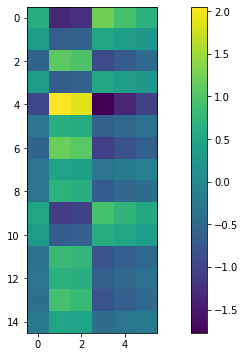

In [ ]:
# Initialization matrix

figure(figsize=[12,6])
subplot(111)
imshow(model_init_norm)
colorbar();show()


In [ ]:
tf_PSF_field_model = TF_PSF_field_model(positions=positions,
                                        x_lims=x_lims,
                                        y_lims=y_lims,
                                        packed_SED_data=packed_SED_data,
                                        psf_batch=psf_batch,
                                        obscurations=tf_obscurations,
                                        tf_zernike_cube=tf_zernike_cube,
                                        output_dim=64,
                                        n_zernikes=15,
                                        d_max=2,
                                        normalize_pos=True,
                                        name=None)

# Model variable initialization
# model_coef_mat = tf.random.uniform(shape=tf_PSF_field_model.tf_poly_Z_field.get_poly_coefficients_shape(),
#                                    minval=-1, maxval=1, dtype=tf.dtypes.float32)

# Try the new initialization 
model_coef_mat = tf.convert_to_tensor(model_init_norm, dtype=tf.dtypes.float32)


tf_PSF_field_model.set_model_params(model_coef_mat)


In [ ]:
time_start = time.time()

# Calculate the PSF batch!
tf_PSF_field_model.calculate_psf_batch()

elapsed_time = time.time() - time_start


In [ ]:
print('Total elapsed time for 3 positions: %f'%elapsed_time)


Total elapsed time for 3 positions: 0.329230


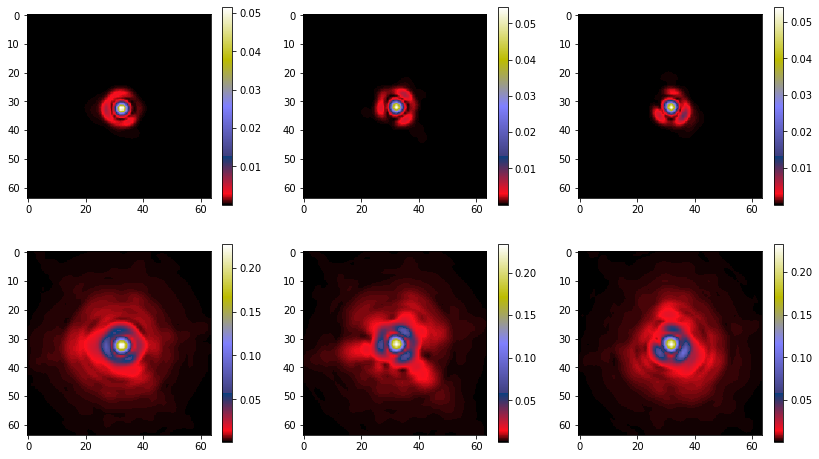

In [ ]:
out_psf_batch = tf_PSF_field_model.psf_batch

figure(figsize=[14,8])
subplot(231)
imshow(out_psf_batch[0,:,:], cmap='gist_stern')
colorbar()

subplot(232)
imshow(out_psf_batch[1,:,:], cmap='gist_stern')
colorbar()

subplot(233)
imshow(out_psf_batch[2,:,:], cmap='gist_stern')
colorbar()

subplot(234)
imshow(tf.math.sqrt(out_psf_batch[0,:,:]), cmap='gist_stern')
colorbar()

subplot(235)
imshow(tf.math.sqrt(out_psf_batch[1,:,:]), cmap='gist_stern')
colorbar()

subplot(236)
imshow(tf.math.sqrt(out_psf_batch[2,:,:]), cmap='gist_stern')
colorbar()


# Calculate the FoV positions and measure the time 




In [ ]:
# train_stars = train_dataset['stars']
# train_pos = train_dataset['positions']
# train_SEDs = train_dataset['SEDs']

# test_stars = test_dataset['stars']
# test_pos = test_dataset['positions']
# test_SEDs = test_dataset['SEDs']


In [ ]:
# Initialization
# Reduce the dataset (not enough memory)
train_stars = train_stars[0:5, :, :]
train_pos = train_pos[0:5, :]
train_SEDs = train_SEDs[0:5, :, :]

# Parameters
pupil_diameter = 512
n_zernikes = 15
output_dim = 64
d_max = 2
batch_size = train_pos.shape[0]
x_lims = [0, 1e3]
y_lims = [0, 1e3]

# Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(zernikes, max_order=n_zernikes, pupil_diameter=pupil_diameter)
simPSF_np.gen_random_Z_coeffs(max_order=n_zernikes)
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=512, N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex128)


# Initialize the SED data list
packed_SED_data = [generate_packed_elems(_sed, simPSF_np, n_bins=20)
                   for _sed in train_SEDs]

# Initialize the poly PSF tensor
psf_batch = tf.zeros((batch_size, output_dim, output_dim), dtype=tf.float64)


# Choose an initialization for the model_parameters
tf_poly_Z_field = TF_poly_Z_field(x_lims, y_lims ,pos=train_pos, n_zernikes=n_zernikes, d_max=d_max, normalize=True)
normalized_pi_mat = tf_poly_Z_field.poly_mat 
np_normalized_pi_mat = normalized_pi_mat.numpy()

init_zernikes = (np.random.rand(batch_size, n_zernikes) - 0.5)*2
init_zernikes /= np.sqrt(np.sum(init_zernikes**2, axis=1)).reshape(-1,1)
init_zernikes *= 0.05
model_init_norm = init_zernikes.T @ np.linalg.pinv(np_normalized_pi_mat)


In [ ]:
# Model variable initialization
# model_coef_mat = tf.random.uniform(shape=tf_PSF_field_model.tf_poly_Z_field.get_poly_coefficients_shape(),
#                                    minval=0, maxval=1, dtype=tf.dtypes.float32)

model_coef_mat = tf.convert_to_tensor(model_init_norm, dtype=tf.dtypes.float32)

In [ ]:
# Initialize the PSF field class

tf_PSF_field_model = TF_PSF_field_model(positions=train_pos,
                                        x_lims=x_lims,
                                        y_lims=y_lims,
                                        packed_SED_data=packed_SED_data,
                                        psf_batch=psf_batch,
                                        obscurations=tf_obscurations,
                                        tf_zernike_cube=tf_zernike_cube,
                                        output_dim=output_dim,
                                        n_zernikes=n_zernikes,
                                        d_max=d_max,
                                        normalize_pos=True,
                                        name=None)



tf_PSF_field_model.set_model_params(model_coef_mat)

In [ ]:
time_start = time.time()

# Calculate the PSF batch!
tf_PSF_field_model.calculate_psf_batch()

elapsed_time = time.time() - time_start



In [ ]:
print('Total elapsed time for %d positions: %f'%(batch_size, elapsed_time))


Total elapsed time for 5 positions: 5.618900


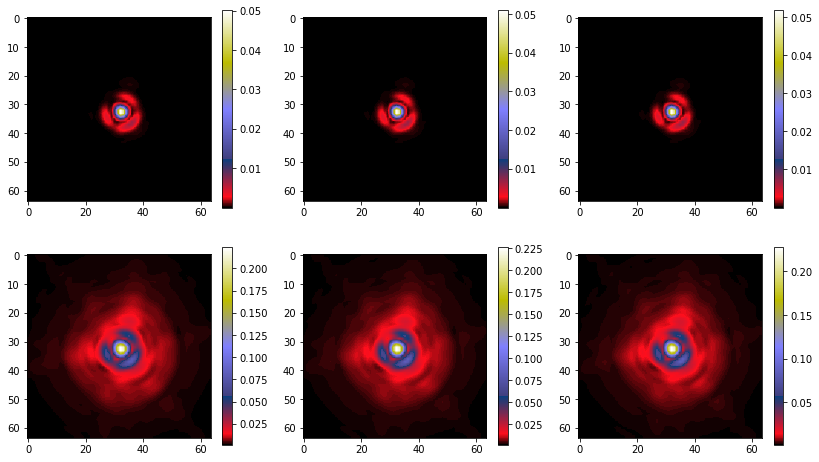

In [ ]:
out_psf_batch = tf_PSF_field_model.psf_batch

figure(figsize=[14,8])
subplot(231)
imshow(out_psf_batch[0,:,:], cmap='gist_stern')
colorbar()

subplot(232)
imshow(out_psf_batch[1,:,:], cmap='gist_stern')
colorbar()

subplot(233)
imshow(out_psf_batch[2,:,:], cmap='gist_stern')
colorbar()

subplot(234)
imshow(tf.math.sqrt(out_psf_batch[0,:,:]), cmap='gist_stern')
colorbar()

subplot(235)
imshow(tf.math.sqrt(out_psf_batch[1,:,:]), cmap='gist_stern')
colorbar()

subplot(236)
imshow(tf.math.sqrt(out_psf_batch[2,:,:]), cmap='gist_stern')
colorbar()

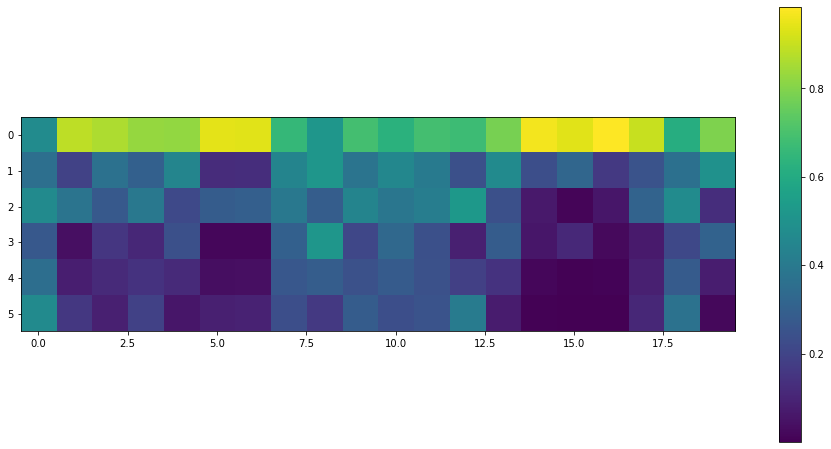

In [ ]:
imshow(np_normalized_pi_mat[:,0:20]);colorbar();show()

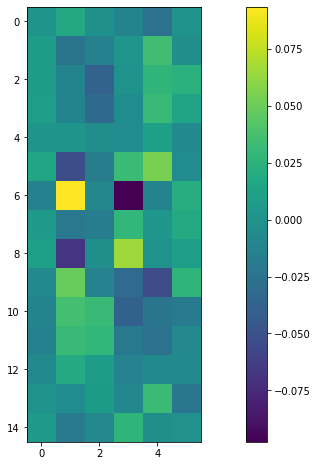

In [ ]:
imshow(model_coef_mat);colorbar();show() 

In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
printm()

Gen RAM Free: 11.3 GB  | Proc size: 2.2 GB
GPU RAM Free: 13162MB | Used: 1917MB | Util  13% | Total 15079MB


# Now let's try some optimisation!


In [ ]:
# The variable to optimise will be the model_coef_mat 
train_model_coef_mat = tf.Variable(model_coef_mat, trainable=True, dtype=tf.float32, name='model_coef_mat')
lamb = tf.constant(1e-7, dtype=train_model_coef_mat.dtype)
target_train_stars = tf.constant(tf.cast(train_stars, tf.float64), dtype=tf.float64)


In [ ]:
# Initialize the PSF field class

tf_PSF_field_model = TF_PSF_field_model(positions=train_pos,
                                        x_lims=x_lims,
                                        y_lims=y_lims,
                                        packed_SED_data=packed_SED_data,
                                        psf_batch=psf_batch,
                                        obscurations=tf_obscurations,
                                        tf_zernike_cube=tf_zernike_cube,
                                        output_dim=output_dim,
                                        n_zernikes=n_zernikes,
                                        d_max=d_max,
                                        normalize_pos=True,
                                        name=None)

# Model variable initialization with the tf variable
tf_PSF_field_model.set_model_params(train_model_coef_mat)

In [ ]:
def loss_psf_field():
    
    # Calculate PSF from train_opd  
    tf_PSF_field_model.calculate_psf_batch()
    data_fidelity = tf.nn.l2_loss(tf_PSF_field_model.psf_batch - target_train_stars)
    # return data_fidelity + lamb * regularisation

    return data_fidelity

loss_psf_field()

<tf.Tensor: shape=(), dtype=float64, numpy=0.11036365351861421>

In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
printm()

Gen RAM Free: 11.3 GB  | Proc size: 2.2 GB
GPU RAM Free: 13162MB | Used: 1917MB | Util  13% | Total 15079MB


In [ ]:
# Optimization algorithm
optimizer = tf.keras.optimizers.SGD(learning_rate=5e1, momentum=.9, nesterov=True)

n_iter = 200
verbose = 1
losses = []

for i_iter in tqdm(range(n_iter)):
    
    optimizer.minimize(loss_psf_field, [train_model_coef_mat])
    losses.append(loss_psf_field())
    if verbose > 0 and i_iter % 1 == 0:
        print(i_iter, loss_psf_field())

loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');

In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
printm()

NameError: ignored